In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install aif360
!pip install BlackBoxAuditing

In [14]:
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import utils.functions as f

# Direct Dataset

In [7]:
dataset = "direct_matching_20240213"
df_processed = pd.read_csv(f"Data/{dataset}_processed.csv", sep=";")

## Gender

In [8]:
sectors = sorted(df_processed.job_sector.unique())
protected_attribute = "cand_gender"

df_mitigation = df_processed.drop(columns=["cand_id", "cand_education", "job_professional_category"]).copy()
columns = df_mitigation.columns
columns = columns.drop(["job_id","job_sector"])

results_df_gender = f.compute_bias_differences(df_mitigation,sectors,protected_attribute,columns)
results_df_gender.to_excel('Results/results_df_gender_direct.xlsx', index=False)
results_df_gender

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Ceco,...,Spagnolo,Croato,Finlandese,Arabo,Danese,Serbo,Portoghese,Ebraico,Rumeno,Cinese
0,316.017899,22.918488,0.0,0.0,0.0,184.0,11.0,0.0,185.0,0.0,...,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,229.424357,0.935387,0.0,0.0,0.0,106.0,22.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,607.821358,27.919029,0.0,0.0,0.0,585.0,128.0,0.0,50.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1146.527752,1.506744,0.0,0.0,0.0,223.0,180.0,0.0,85.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
4,907.004792,50.070999,0.0,0.0,0.0,953.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1347.359169,66.988174,0.0,0.0,0.0,464.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,261.838385,9.574043,0.0,0.0,0.0,484.0,159.0,0.0,180.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1429.262764,67.327622,0.0,0.0,0.0,1721.0,1260.0,0.0,412.0,1.0,...,0.0,0.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
8,509.016976,74.356888,0.0,0.0,0.0,955.0,248.0,0.0,780.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,624.899319,4.731728,0.0,0.0,0.0,346.0,85.0,0.0,0.0,0.0,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


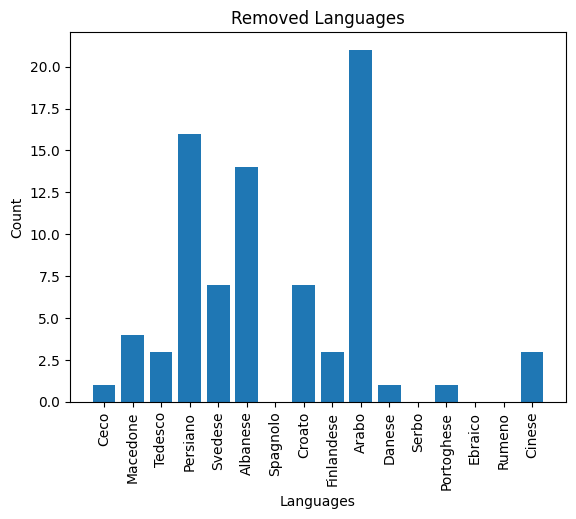

In [16]:
sums_gender = results_df_gender.iloc[:, 9:].sum()

f.plot_series(sums_gender,'Removed Languages','Languages')

In [10]:
job_df_orig_gender, job_df_repaired_gender = f.compute_repaired_df(df_mitigation,7,protected_attribute)

In [11]:
with open('Encodings/direct_matching_20240213_cand_domicile_region_encoding.json', 'r') as file:
    region_mapping = json.load(file)
with open('Encodings/direct_matching_20240213_provinces_encoding.json', 'r') as file:
    province_mapping = json.load(file)

reversed_region_mapping = {v: k for k, v in region_mapping.items()}
reversed_province_mapping = {v: k for k, v in province_mapping.items()}

job_df_orig_gender['cand_domicile_region_str'] = job_df_orig_gender['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_gender['cand_domicile_region_str'] = job_df_repaired_gender['cand_domicile_region'].map(reversed_region_mapping)

job_df_orig_gender['cand_domicile_province_str'] = job_df_orig_gender['cand_domicile_province'].map(reversed_province_mapping)
job_df_repaired_gender['cand_domicile_province_str'] = job_df_repaired_gender['cand_domicile_province'].map(reversed_province_mapping)

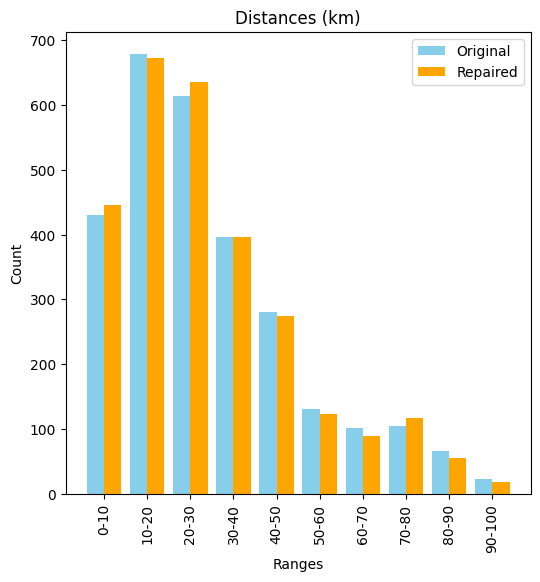

In [17]:
distances_km1 = job_df_orig_gender.distance_km
distances_km_origin = f.discretize_feature(distances_km1)
distances_km2 = job_df_repaired_gender.distance_km
distances_km_repaired = f.discretize_feature(distances_km2)

labels = [f'{i*10}-{(i+1)*10}' for i in range(10)]

f.compare_plot(distances_km_origin,distances_km_repaired,labels, 'Distances (km)','Ranges')

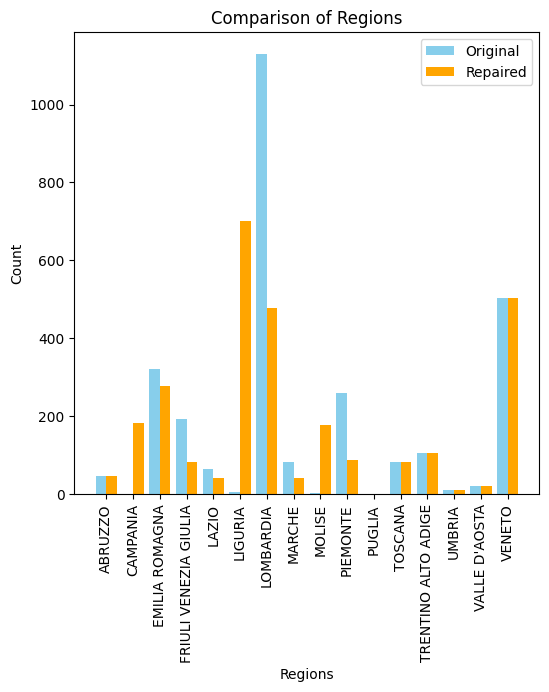

In [18]:
orig_counts = job_df_orig_gender['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_gender['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

## Age

In [20]:
protected_attribute_age = "cand_age_bucket"

results_df_age = f.compute_bias_differences(df_mitigation,sectors,protected_attribute_age,columns)
results_df_age.to_excel('Results/results_df_age_direct.xlsx', index=False)
results_df_age

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Ceco,...,Spagnolo,Croato,Finlandese,Arabo,Danese,Serbo,Portoghese,Ebraico,Rumeno,Cinese
0,304.399663,7.395134,0.0,0.0,0.0,335.0,73.0,0.0,-68.0,0.0,...,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,228.615830,-2.070259,66.0,0.0,0.0,356.0,11.0,0.0,-220.0,0.0,...,5.0,2.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
2,-91.183931,-8.566383,47.0,0.0,0.0,15.0,548.0,0.0,1986.0,0.0,...,0.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-465.383827,0.557617,40.0,0.0,0.0,70.0,185.0,0.0,444.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
4,291.609679,46.502220,81.0,0.0,0.0,402.0,856.0,0.0,404.0,0.0,...,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,37.250072,0.791176,0.0,0.0,0.0,253.0,440.0,0.0,850.0,0.0,...,0.0,8.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
6,137.898669,-9.060768,22.0,0.0,0.0,189.0,264.0,0.0,171.0,0.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,14.0,0.0,0.0
7,-301.192693,-35.694054,0.0,0.0,0.0,403.0,537.0,0.0,-117.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,164.006248,-3.043098,0.0,0.0,0.0,134.0,175.0,0.0,485.0,0.0,...,28.0,0.0,1.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0
9,-9.197868,6.826012,46.0,0.0,0.0,66.0,342.0,0.0,823.0,0.0,...,11.0,4.0,0.0,1.0,0.0,0.0,0.0,16.0,43.0,0.0


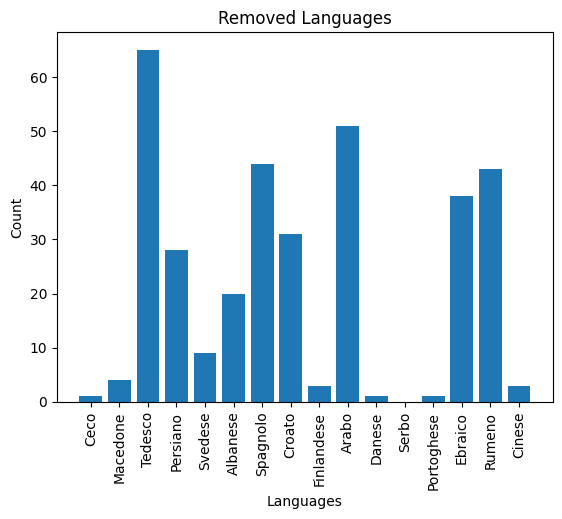

In [21]:
sums_age = results_df_age.iloc[:, 9:].sum()

f.plot_series(sums_age,'Removed Languages','Languages')

In [22]:
job_df_orig_age, job_df_repaired_age = f.compute_repaired_df(df_mitigation,2,protected_attribute_age)
job_df_orig_age['job_work_province_str'] = job_df_orig_age['job_work_province'].map(reversed_province_mapping)
job_df_repaired_age['job_work_province_str'] = job_df_repaired_age['job_work_province'].map(reversed_province_mapping)

job_df_orig_age['cand_domicile_region_str'] = job_df_orig_age['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_age['cand_domicile_region_str'] = job_df_repaired_age['cand_domicile_region'].map(reversed_region_mapping)

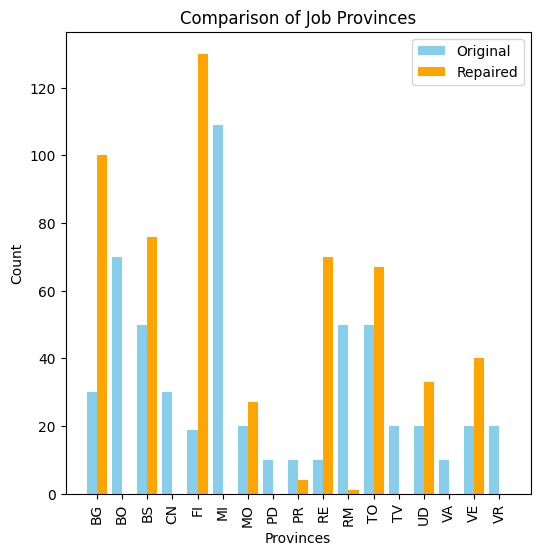

In [23]:
orig_counts = job_df_orig_age['job_work_province_str'].value_counts()
repaired_counts = job_df_repaired_age['job_work_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Job Provinces','Provinces')

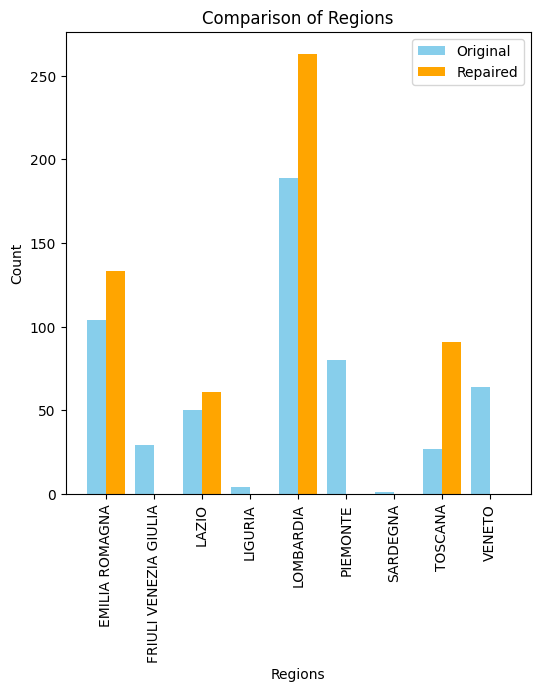

In [24]:
orig_counts = job_df_orig_age['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_age['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

## Location

In [25]:
protected_attribute_location = "same_location"

results_df_location = f.compute_bias_differences(df_mitigation,sectors,protected_attribute_location,columns)
results_df_location.to_excel('Results/results_df_location_direct.xlsx', index=False)
results_df_location

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Ceco,...,Croato,Finlandese,Arabo,Danese,Serbo,Portoghese,Ebraico,Rumeno,Cinese,same_location
0,7859.605473,17.784119,0.0,0.0,0.0,1440.0,427.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2587.806569,1.985207,0.0,0.0,0.0,231.0,247.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6467.913466,10.770035,0.0,0.0,0.0,2249.0,34.0,0.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6169.671333,5.900627,0.0,0.0,0.0,611.0,349.0,0.0,297.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
4,6472.513154,28.117096,0.0,0.0,0.0,1214.0,918.0,0.0,1149.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,15849.094067,60.437744,0.0,0.0,0.0,3772.0,33.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4502.474936,8.895142,0.0,0.0,0.0,510.0,305.0,0.0,360.0,0.0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22050.899386,126.559105,0.0,0.0,0.0,2880.0,1800.0,0.0,1195.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,10099.362573,24.148232,0.0,0.0,0.0,1825.0,310.0,0.0,776.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,5246.018154,7.922150,0.0,0.0,0.0,864.0,354.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


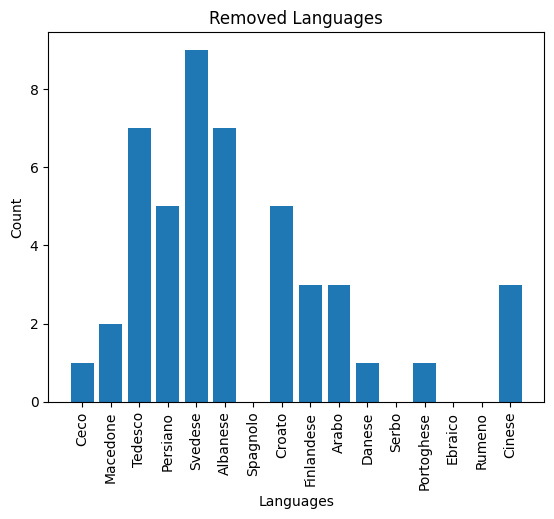

In [26]:
sums_location = results_df_location.iloc[:, 9:-1].sum()

f.plot_series(sums_location,'Removed Languages','Languages')

In [27]:
job_df_orig_location, job_df_repaired_location = f.compute_repaired_df(df_mitigation,7,protected_attribute_location)
job_df_orig_location['job_work_province_str'] = job_df_orig_location['job_work_province'].map(reversed_province_mapping)
job_df_repaired_location['job_work_province_str'] = job_df_repaired_location['job_work_province'].map(reversed_province_mapping)

job_df_orig_location['cand_domicile_province_str'] = job_df_orig_location['cand_domicile_province'].map(reversed_province_mapping)
job_df_repaired_location['cand_domicile_province_str'] = job_df_repaired_location['cand_domicile_province'].map(reversed_province_mapping)

job_df_orig_location['cand_domicile_region_str'] = job_df_orig_location['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_location['cand_domicile_region_str'] = job_df_repaired_location['cand_domicile_region'].map(reversed_region_mapping)

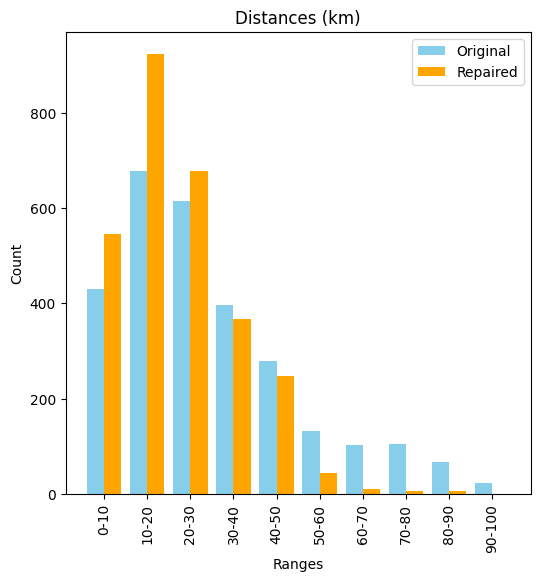

In [28]:
distances_km1 = job_df_orig_location.distance_km
distances_km_origin = f.discretize_feature(distances_km1)
distances_km2 = job_df_repaired_location.distance_km
distances_km_repaired = f.discretize_feature(distances_km2)

labels = [f'{i*10}-{(i+1)*10}' for i in range(10)]

f.compare_plot(distances_km_origin,distances_km_repaired,labels, 'Distances (km)','Ranges')

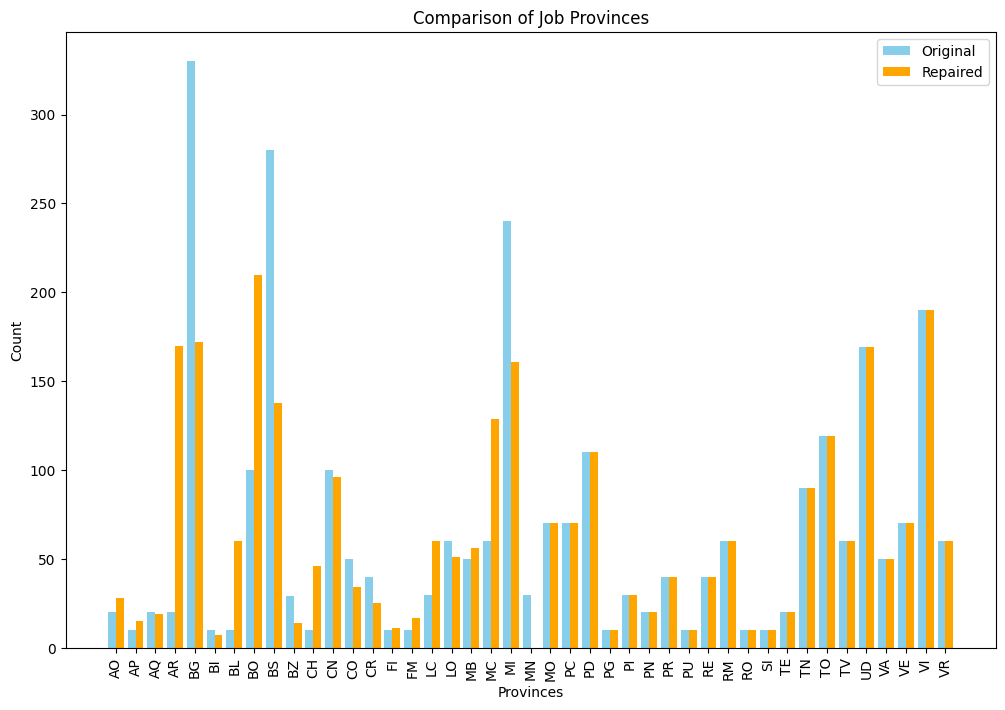

In [29]:
orig_counts = job_df_orig_location['job_work_province_str'].value_counts()
repaired_counts = job_df_repaired_location['job_work_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Job Provinces','Provinces',size=(12,8))

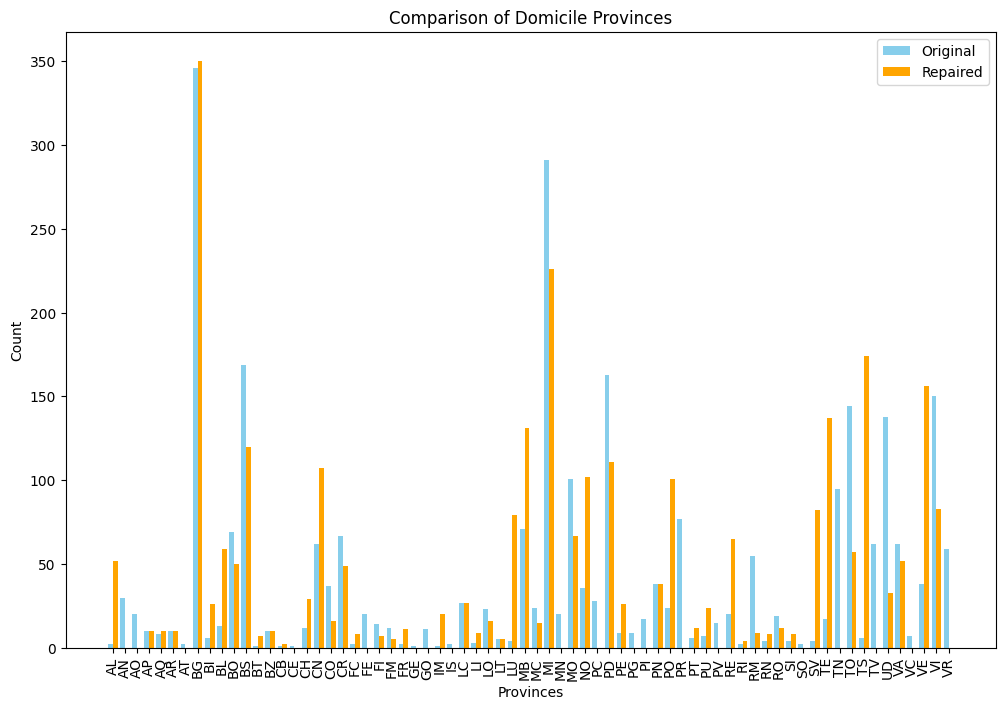

In [30]:
orig_counts = job_df_orig_location['cand_domicile_province_str'].value_counts()
repaired_counts = job_df_repaired_location['cand_domicile_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Domicile Provinces','Provinces',size=(12,8))

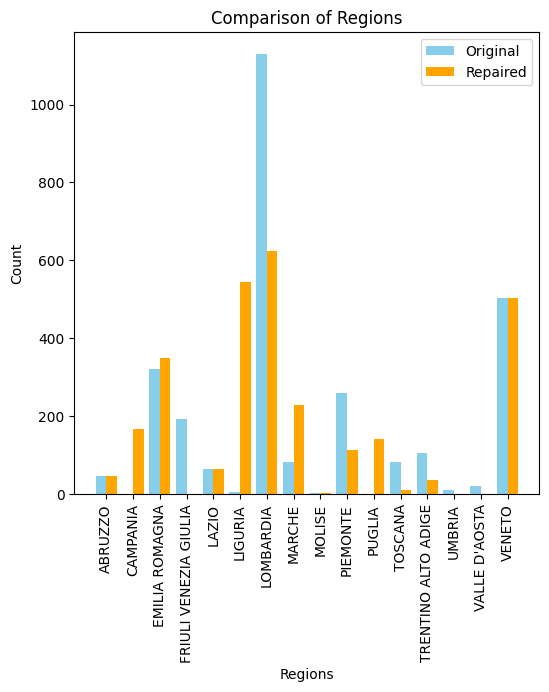

In [31]:
orig_counts = job_df_orig_location['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_location['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

# Reverse Dataset


In [75]:
dataset = "reverse_matching_20240213"
df_processed = pd.read_csv(f"Data/{dataset}_processed.csv", sep=";")
df_mitigation = df_processed.drop(columns=["cand_id", "cand_education", "job_professional_category"]).copy()
columns = df_mitigation.columns
columns = columns.drop(["job_id","job_sector"])
sectors = sorted(df_processed.job_sector.unique())
sectors = sectors[:-1]

## Gender

In [48]:
protected_attribute = "cand_gender"

results_df_gender = f.compute_bias_differences(df_mitigation,sectors,protected_attribute,columns)
results_df_gender.to_excel('Results/results_df_gender_reverse.xlsx', index=False)
results_df_gender

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Pakistano - Urdu,...,Macedone,Portoghese,Sloveno,Catalano,Svedese,Croato,Arabo,Serbo,Norvegese,Cinese
0,10664.496647,13429.193563,0.0,0.0,0.0,9501.0,0.0,0.0,6852.0,5.0,...,0.0,15.0,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0
1,1409.827733,426.637711,0.0,0.0,0.0,424.0,139.0,0.0,1096.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3480.807214,1130.169756,0.0,0.0,0.0,2835.0,781.0,3.0,1379.0,0.0,...,1.0,10.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0
3,5872.514622,9061.814205,0.0,0.0,0.0,8393.0,0.0,0.0,4460.0,3.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3868.738883,6483.827062,0.0,0.0,0.0,3281.0,0.0,0.0,11339.0,16.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
5,826.666415,1693.771610,0.0,0.0,0.0,914.0,154.0,3.0,2527.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
6,377.308583,314.287271,0.0,0.0,0.0,1463.0,361.0,0.0,3986.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,2347.762371,13515.897057,0.0,0.0,0.0,7216.0,0.0,0.0,3925.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
8,11221.834551,18746.473992,0.0,0.0,0.0,10188.0,7563.0,0.0,4160.0,0.0,...,0.0,2.0,1.0,5.0,0.0,0.0,0.0,0.0,10.0,0.0
9,1895.335162,8148.668345,0.0,0.0,0.0,16687.0,0.0,0.0,19652.0,10.0,...,0.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,3.0,0.0


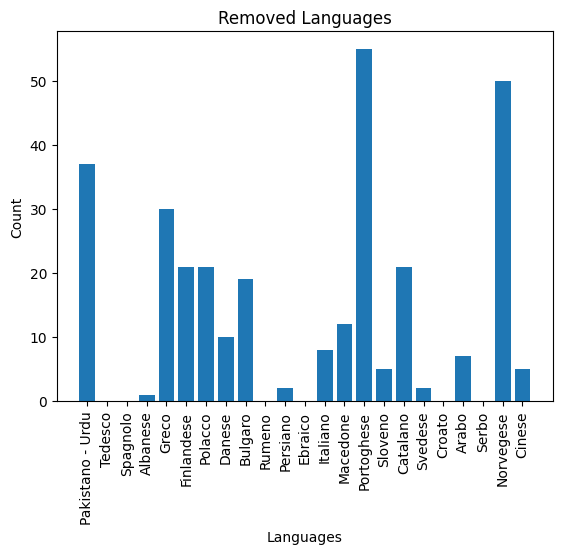

In [51]:
sums_gender = results_df_gender.iloc[:, 9:].sum()

f.plot_series(sums_gender,'Removed Languages','Languages')

In [52]:
job_df_orig_gender, job_df_repaired_gender = f.compute_repaired_df(df_mitigation,8,protected_attribute)

In [53]:
with open('Encodings/reverse_matching_20240213_cand_domicile_region_encoding.json', 'r') as file:
    region_mapping = json.load(file)
with open('Encodings/reverse_matching_20240213_provinces_encoding.json', 'r') as file:
    province_mapping = json.load(file)

reversed_region_mapping = {v: k for k, v in region_mapping.items()}
reversed_province_mapping = {v: k for k, v in province_mapping.items()}

job_df_orig_gender['cand_domicile_region_str'] = job_df_orig_gender['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_gender['cand_domicile_region_str'] = job_df_repaired_gender['cand_domicile_region'].map(reversed_region_mapping)

job_df_orig_gender['cand_domicile_province_str'] = job_df_orig_gender['cand_domicile_province'].map(reversed_province_mapping)
job_df_repaired_gender['cand_domicile_province_str'] = job_df_repaired_gender['cand_domicile_province'].map(reversed_province_mapping)

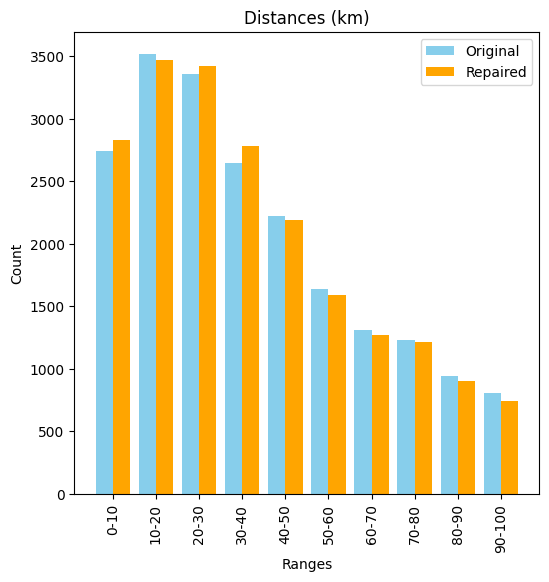

In [54]:
distances_km1 = job_df_orig_gender.distance_km
distances_km_origin = f.discretize_feature(distances_km1)
distances_km2 = job_df_repaired_gender.distance_km
distances_km_repaired = f.discretize_feature(distances_km2)

labels = [f'{i*10}-{(i+1)*10}' for i in range(10)]

f.compare_plot(distances_km_origin,distances_km_repaired,labels, 'Distances (km)','Ranges')

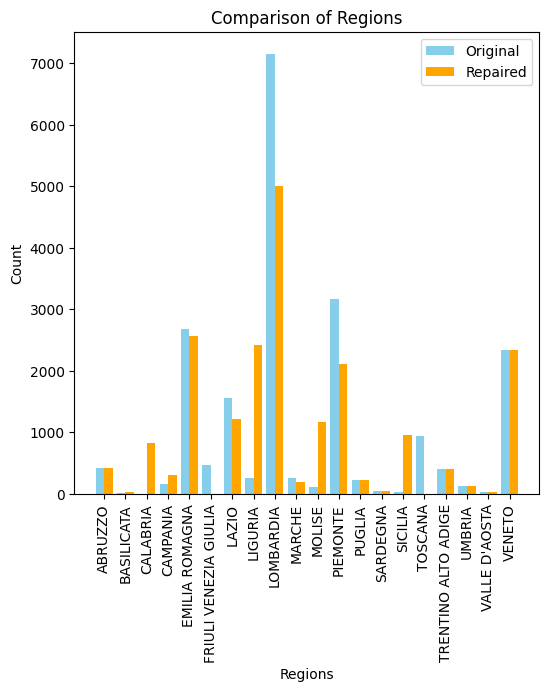

In [55]:
orig_counts = job_df_orig_gender['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_gender['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

## Age

In [76]:
protected_attribute_age = "cand_age_bucket"

results_df_age = f.compute_bias_differences(df_mitigation,sectors,protected_attribute_age,columns)
results_df_age.to_excel('Results/results_df_age_reverse.xlsx', index=False)
results_df_age

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Pakistano - Urdu,...,Macedone,Portoghese,Sloveno,Catalano,Svedese,Croato,Arabo,Serbo,Norvegese,Cinese
0,3408.105137,436.446233,0.0,0.0,0.0,1843.0,1835.0,0.0,-911.0,5.0,...,15.0,15.0,0.0,2.0,25.0,0.0,124.0,0.0,6.0,44.0
1,665.760877,-148.687105,0.0,0.0,0.0,46.0,706.0,0.0,580.0,0.0,...,5.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0
2,1249.197527,971.603741,0.0,0.0,0.0,957.0,1518.0,3.0,-192.0,0.0,...,1.0,10.0,1.0,1.0,1.0,34.0,30.0,0.0,10.0,7.0
3,6441.565458,-2081.591256,0.0,0.0,0.0,359.0,3082.0,13.0,2767.0,3.0,...,4.0,0.0,0.0,5.0,7.0,0.0,64.0,0.0,0.0,28.0
4,6418.643808,-4.464336,0.0,0.0,0.0,2829.0,2769.0,0.0,-3157.0,16.0,...,28.0,1.0,1.0,10.0,65.0,0.0,154.0,0.0,9.0,83.0
5,302.670879,40.662559,0.0,0.0,0.0,-890.0,290.0,3.0,874.0,0.0,...,1.0,1.0,0.0,0.0,1.0,10.0,6.0,0.0,0.0,2.0
6,425.265619,-155.884795,0.0,0.0,0.0,490.0,246.0,10.0,-998.0,0.0,...,1.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,1.0
7,9091.964588,-499.647383,0.0,0.0,0.0,-539.0,-3242.0,3.0,12061.0,0.0,...,19.0,8.0,0.0,6.0,24.0,0.0,126.0,0.0,5.0,36.0
8,379.765564,-991.810523,0.0,0.0,0.0,9028.0,-10716.0,0.0,1.0,0.0,...,4.0,2.0,1.0,5.0,10.0,0.0,152.0,0.0,10.0,24.0
9,6031.146319,-703.248936,0.0,0.0,0.0,230.0,2383.0,0.0,2710.0,10.0,...,4.0,1.0,1.0,7.0,61.0,0.0,147.0,0.0,3.0,64.0


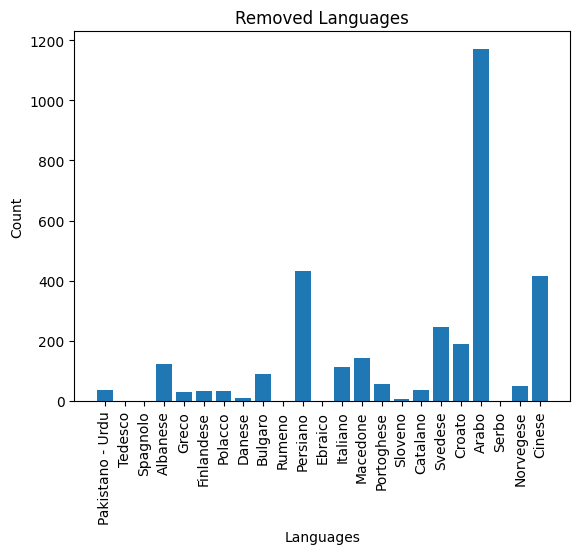

In [57]:
sums_age = results_df_age.iloc[:, 9:].sum()

f.plot_series(sums_age,'Removed Languages','Languages')

In [59]:
job_df_orig_age, job_df_repaired_age = f.compute_repaired_df(df_mitigation,11,protected_attribute_age)
job_df_orig_age['job_work_province_str'] = job_df_orig_age['job_work_province'].map(reversed_province_mapping)
job_df_repaired_age['job_work_province_str'] = job_df_repaired_age['job_work_province'].map(reversed_province_mapping)

job_df_orig_age['cand_domicile_region_str'] = job_df_orig_age['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_age['cand_domicile_region_str'] = job_df_repaired_age['cand_domicile_region'].map(reversed_region_mapping)

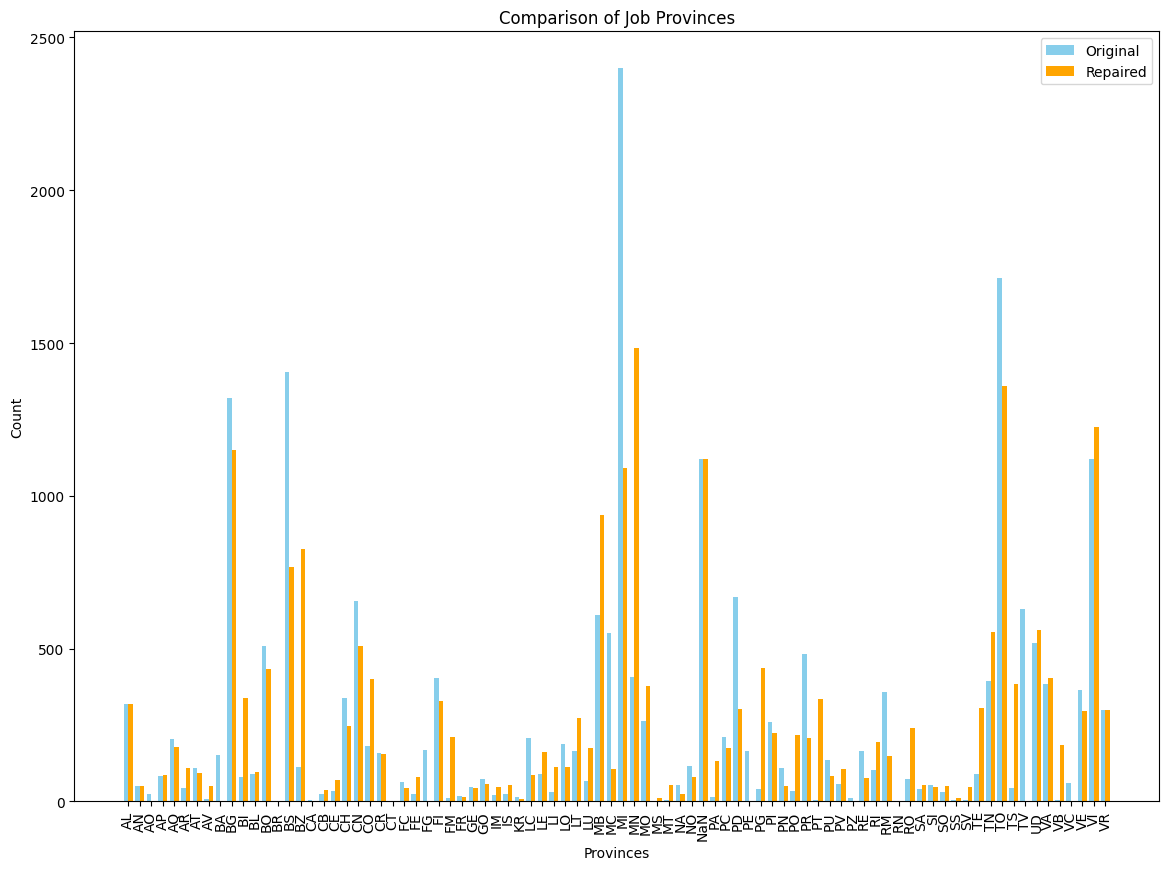

In [63]:
orig_counts = job_df_orig_age['job_work_province_str'].value_counts()
repaired_counts = job_df_repaired_age['job_work_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Job Provinces','Provinces',size=(14,10))

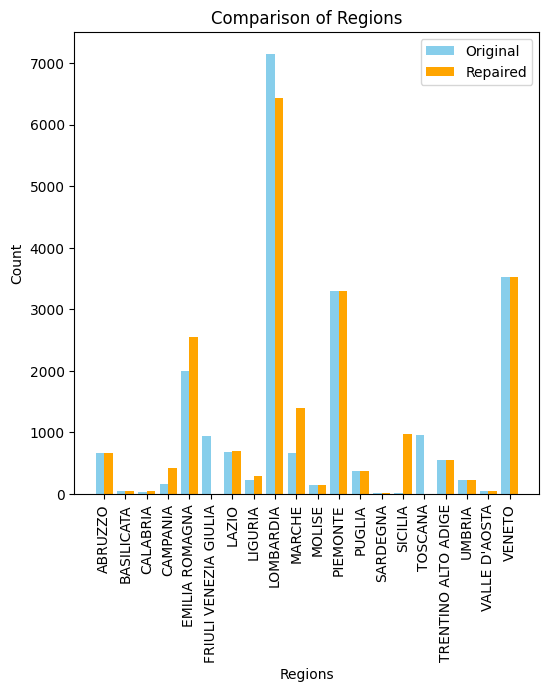

In [64]:
orig_counts = job_df_orig_age['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_age['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

## Location

In [73]:
protected_attribute_location = "same_location"

results_df_location = f.compute_bias_differences(df_mitigation,sectors,protected_attribute_location,columns)
results_df_location.to_excel('Results/results_df_location_reverse.xlsx', index=False)
results_df_location

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Pakistano - Urdu,...,Portoghese,Sloveno,Catalano,Svedese,Croato,Arabo,Serbo,Norvegese,Cinese,same_location
0,285365.722165,19077.874315,0.0,0.0,0.0,17048.0,3245.0,0.0,25498.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16360.150209,1957.138701,0.0,0.0,0.0,1159.0,705.0,0.0,3212.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94292.971128,3937.469963,0.0,0.0,0.0,5713.0,2177.0,0.0,6671.0,0.0,...,10.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,245510.548200,17391.542955,0.0,0.0,0.0,12142.0,0.0,0.0,17815.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,310482.718883,20669.642103,0.0,0.0,0.0,9573.0,0.0,0.0,18356.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,21713.292789,676.959940,0.0,0.0,0.0,1601.0,789.0,0.0,2695.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
6,28003.139985,1615.217432,0.0,0.0,0.0,1483.0,222.0,0.0,2229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,351984.142645,23236.529212,0.0,0.0,0.0,15461.0,4450.0,3.0,23152.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,302308.135712,14006.515957,0.0,0.0,0.0,12415.0,9536.0,0.0,6785.0,0.0,...,2.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,367062.138159,26065.102072,0.0,0.0,0.0,35878.0,48.0,0.0,36946.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


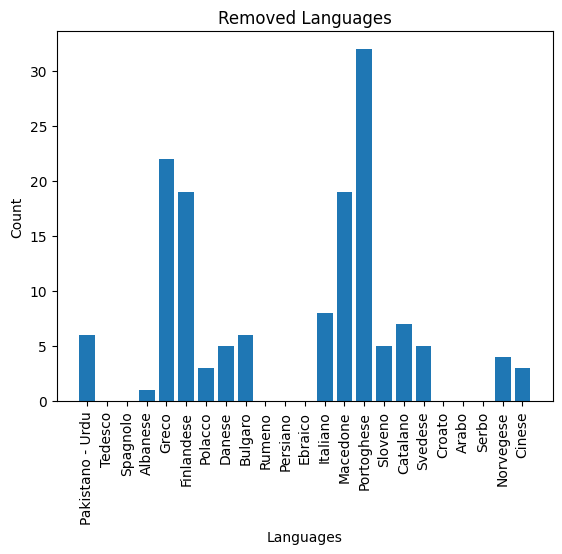

In [66]:
sums_location = results_df_location.iloc[:, 9:-1].sum()

f.plot_series(sums_location,'Removed Languages','Languages')

In [67]:
job_df_orig_location, job_df_repaired_location = f.compute_repaired_df(df_mitigation,7,protected_attribute_location)
job_df_orig_location['job_work_province_str'] = job_df_orig_location['job_work_province'].map(reversed_province_mapping)
job_df_repaired_location['job_work_province_str'] = job_df_repaired_location['job_work_province'].map(reversed_province_mapping)

job_df_orig_location['cand_domicile_province_str'] = job_df_orig_location['cand_domicile_province'].map(reversed_province_mapping)
job_df_repaired_location['cand_domicile_province_str'] = job_df_repaired_location['cand_domicile_province'].map(reversed_province_mapping)

job_df_orig_location['cand_domicile_region_str'] = job_df_orig_location['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_location['cand_domicile_region_str'] = job_df_repaired_location['cand_domicile_region'].map(reversed_region_mapping)

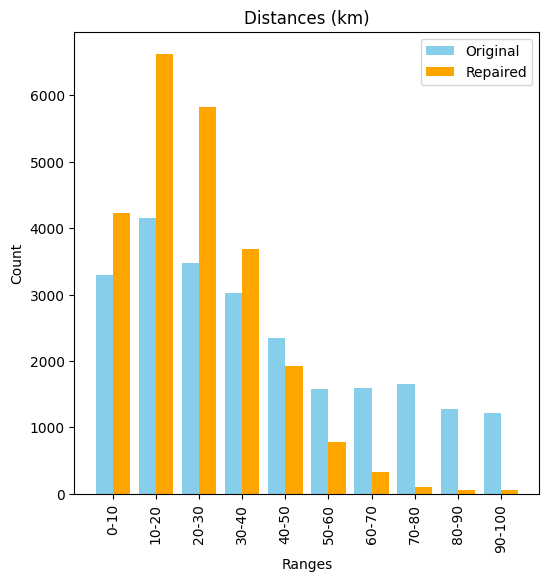

In [68]:
distances_km1 = job_df_orig_location.distance_km
distances_km_origin = f.discretize_feature(distances_km1)
distances_km2 = job_df_repaired_location.distance_km
distances_km_repaired = f.discretize_feature(distances_km2)

labels = [f'{i*10}-{(i+1)*10}' for i in range(10)]

f.compare_plot(distances_km_origin,distances_km_repaired,labels, 'Distances (km)','Ranges')

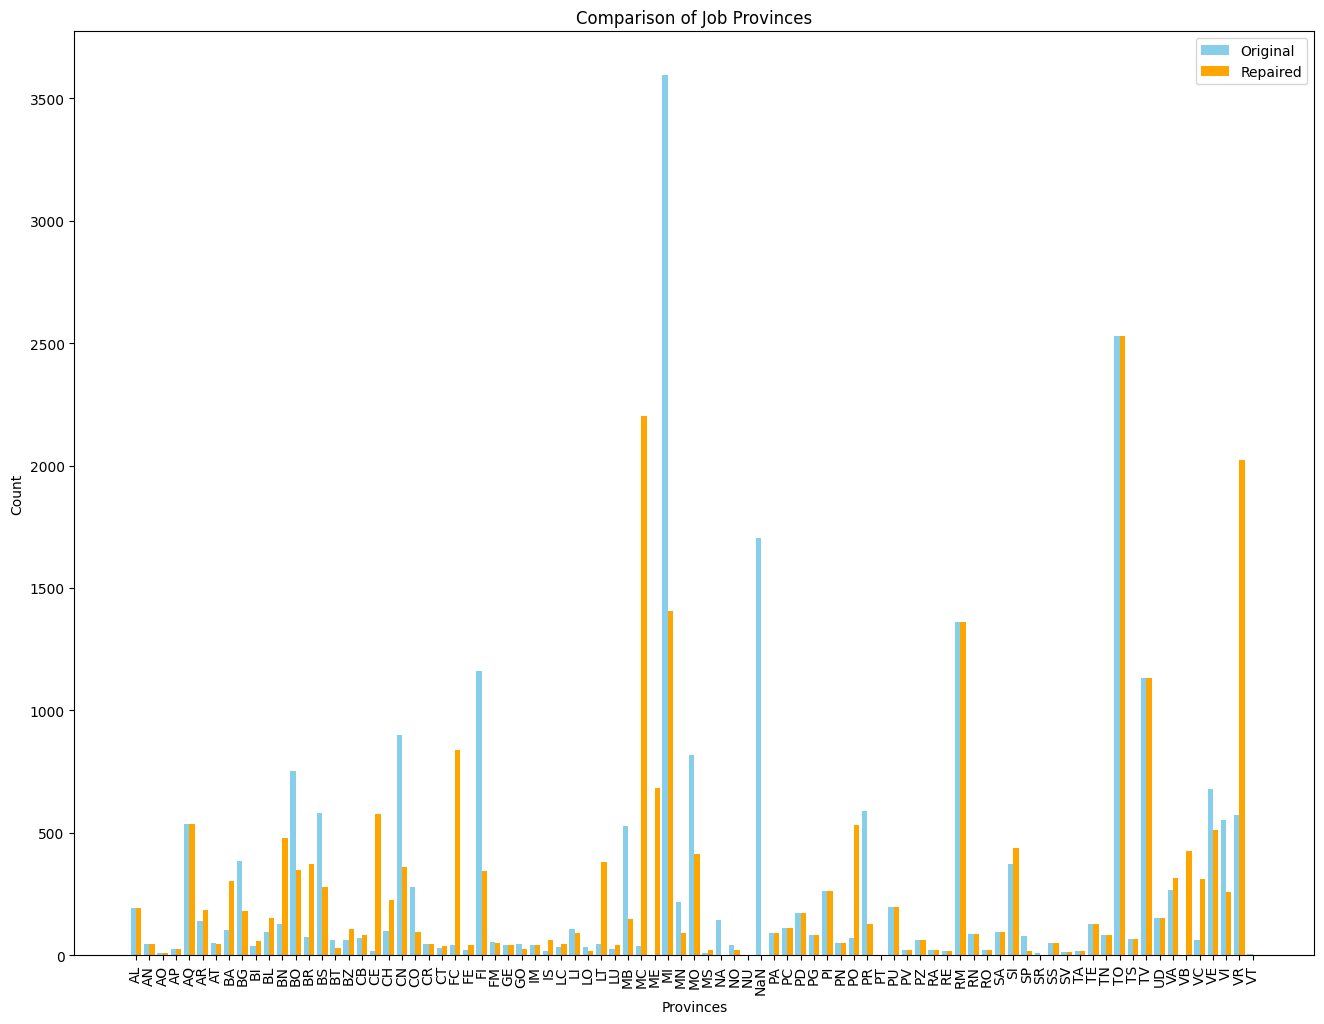

In [71]:
orig_counts = job_df_orig_location['job_work_province_str'].value_counts()
repaired_counts = job_df_repaired_location['job_work_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Job Provinces','Provinces',size=(16,12))

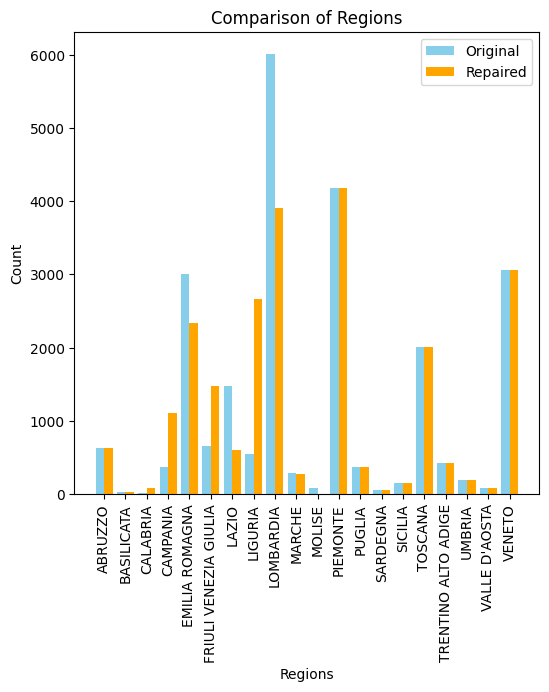

In [72]:
orig_counts = job_df_orig_location['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_location['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')